In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import joblib

In [ ]:


drive.mount('/content/drive')

# Load data
df = pd.read_csv('/content/street_light_fault_prediction_dataset.csv')

# Feature engineering - EXACTLY matching original training process
def create_features(df):
    # Basic timestamp features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Handle outliers
    numeric_cols = ['power_consumption (Watts)', 'voltage_levels (Volts)',
                   'current_fluctuations (Amperes)', 'temperature (Celsius)',
                   'current_fluctuations_env (Amperes)']

    for col in numeric_cols:
        upper_limit = df[col].quantile(0.99)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

    # Rolling features (window=5 only) - with EXACT naming the models expect
    df.sort_values(['bulb_number', 'timestamp'], inplace=True)
    window = 5

    rolling_cols = ['power_consumption (Watts)', 'voltage_levels (Volts)', 'current_fluctuations (Amperes)']
    for col in rolling_cols:
        # Using FULL column names in the rolling features as models expect
        df[f'{col}_rolling_avg'] = df.groupby('bulb_number')[col].transform(
            lambda x: x.rolling(window, min_periods=1).mean())
        df[f'{col}_rolling_std'] = df.groupby('bulb_number')[col].transform(
            lambda x: x.rolling(window, min_periods=1).std())

    # Days since last record
    df['days_since_last_record'] = df.groupby('bulb_number')['timestamp'].diff().dt.days.fillna(0)

    # Electrical features
    df['power_voltage_ratio'] = df['power_consumption (Watts)'] / df['voltage_levels (Volts)']
    df['current_imbalance'] = df['current_fluctuations (Amperes)'] - df['current_fluctuations_env (Amperes)']

    # Categorical features
    df['is_rainy'] = (df['environmental_conditions'] == 'Rainy').astype(int)
    df['is_cloudy'] = (df['environmental_conditions'] == 'Cloudy').astype(int)
    df['has_fault'] = (df['fault_type'] != 0).astype(int)

    return df

df = create_features(df)

# Feature selection - EXACTLY matching original feature names
features = [
    'bulb_number',
    'power_consumption (Watts)',
    'voltage_levels (Volts)',
    'current_fluctuations (Amperes)',
    'temperature (Celsius)',
    'current_fluctuations_env (Amperes)',
    'power_consumption (Watts)_rolling_avg',  # Full column names
    'voltage_levels (Volts)_rolling_avg',     # Full column names
    'current_fluctuations (Amperes)_rolling_avg',  # Full column names
    'power_consumption (Watts)_rolling_std',  # Full column names
    'voltage_levels (Volts)_rolling_std',     # Full column names
    'current_fluctuations (Amperes)_rolling_std',  # Full column names
    'days_since_last_record',  # Added missing feature
    'hour',
    'day_of_week',
    'month',
    'is_weekend',
    'is_rainy',
    'is_cloudy',
    'power_voltage_ratio',
    'current_imbalance'
]

target_binary = 'has_fault'
target_multiclass = 'fault_type'

# Prepare data
X = df[features]
y_binary = df[target_binary]
y_multiclass = df[target_multiclass]

# Load models
models = {
    'binary': {
        'gradient_boosting': joblib.load('/content/drive/MyDrive/all_models/binary_gradient_boosting.joblib'),
        'logistic_regression': joblib.load('/content/drive/MyDrive/all_models/binary_logistic_regression.joblib'),
        'xgboost': joblib.load('/content/drive/MyDrive/all_models/binary_xgboost.joblib'),
        'random_forest': joblib.load('/content/drive/MyDrive/all_models/binary_random_forest.joblib'),
    },
    'multiclass': {
        'gradient_boosting': joblib.load('/content/drive/MyDrive/all_models/multiclass_gradient_boosting.joblib'),
        'xgboost': joblib.load('/content/drive/MyDrive/all_models/multiclass_xgboost.joblib'),
        'random_forest': joblib.load('/content/drive/MyDrive/all_models/multiclass_random_forest.joblib')
    }
}

# Evaluation function
def evaluate_model(model, X, y, model_name, model_type='binary'):
    print(f"\nEvaluating {model_type} model: {model_name}")

    try:
        y_pred = model.predict(X)

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred, average='weighted'),
            'recall': recall_score(y, y_pred, average='weighted'),
            'f1': f1_score(y, y_pred, average='weighted')
        }

        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X)
            if model_type == 'binary' and y_proba.shape[1] == 2:
                metrics['roc_auc'] = roc_auc_score(y, y_proba[:, 1])
            elif model_type == 'multiclass':
                try:
                    metrics['roc_auc'] = roc_auc_score(y, y_proba, multi_class='ovr')
                except:
                    metrics['roc_auc'] = None

        print(f"\nClassification Report for {model_name}:")
        print(classification_report(y, y_pred))

        return metrics

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None

# Evaluate all models
results = {}

for model_type in models:
    results[model_type] = {}
    y_true = y_binary if model_type == 'binary' else y_multiclass

    for model_name, model in models[model_type].items():
        results[model_type][model_name] = evaluate_model(
            model, X, y_true, model_name, model_type
        )

# Display results
print("\nFinal Model Performance Summary:")
for model_type in results:
    print(f"\n{model_type.upper()} CLASSIFICATION MODELS")
    print("="*50)

    # Filter out None results
    valid_results = {k: v for k, v in results[model_type].items() if v is not None}

    if valid_results:
        df_results = pd.DataFrame(valid_results).T
        print(df_results.sort_values('f1', ascending=False))
    else:
        print(f"No valid results for {model_type} models")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Evaluating binary model: gradient_boosting

Classification Report for gradient_boosting:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     24111
           1       1.00      0.48      0.65     10199

    accuracy                           0.85     34310
   macro avg       0.91      0.74      0.78     34310
weighted avg       0.87      0.85      0.83     34310


Evaluating binary model: logistic_regression

Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     24111
           1       0.69      0.33      0.45     10199

    accuracy                           0.76     34310
   macro avg       0.73      0.63      0.65     34310
weighted avg       0.74      0.76      0.73     34310


Evaluating binary model: xgboost

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, accuracy_score,
                           precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, roc_curve,
                           precision_recall_curve)
from google.colab import drive
import joblib

In [ ]:
# Load the preprocessed data and models (from previous steps)
# X, y_binary, y_multiclass, models should be available

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels=None):
    """Plot a styled confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def plot_roc_curve(y_true, y_score, model_name):
    """Plot ROC curve for binary classification"""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc_score(y_true, y_score):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def plot_precision_recall(y_true, y_score, model_name):
    """Plot precision-recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="best")
    plt.show()

In [ ]:
def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """Plot feature importance if available"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:]

        plt.figure(figsize=(10, 8))
        plt.title(f'Feature Importances - {model_name}')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    elif hasattr(model, 'coef_'):
        coef = model.coef_[0]
        indices = np.argsort(np.abs(coef))[-top_n:]

        plt.figure(figsize=(10, 8))
        plt.title(f'Feature Coefficients - {model_name}')
        plt.barh(range(len(indices)), coef[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Coefficient Value')
        plt.show()


In [ ]:
def evaluate_model(model, X, y_true, model_name, model_type='binary'):
    """Comprehensive model evaluation with visualizations"""
    print(f"\n{'='*50}")
    print(f"Evaluating {model_type} model: {model_name}")
    print(f"{'='*50}")

    try:
        # Get predictions and probabilities
        y_pred = model.predict(X)

        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X)[:, 1] if model_type == 'binary' else model.predict_proba(X)
        else:
            y_score = None

        # Calculate metrics
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, average='weighted'),
            'Recall': recall_score(y_true, y_pred, average='weighted'),
            'F1 Score': f1_score(y_true, y_pred, average='weighted')
        }

        if y_score is not None:
            if model_type == 'binary':
                metrics['AUC-ROC'] = roc_auc_score(y_true, y_score)
            else:
                try:
                    metrics['AUC-ROC (OvR)'] = roc_auc_score(y_true, y_score, multi_class='ovr')
                except:
                    pass

        # Display metrics in a nice table
        metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
        print("\nPerformance Metrics:")
        display(metrics_df.style.format("{:.3f}").background_gradient(cmap='Blues'))

        # Classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred))

        # Visualizations
        if model_type == 'binary':
            # Confusion Matrix
            plot_confusion_matrix(y_true, y_pred, model_name,
                                class_labels=['No Fault', 'Fault'])

            # ROC Curve
            if y_score is not None:
                plot_roc_curve(y_true, y_score, model_name)
                plot_precision_recall(y_true, y_score, model_name)
        else:
            # For multiclass, show confusion matrix with all classes
            plot_confusion_matrix(y_true, y_pred, model_name,
                               class_labels=sorted(y_true.unique()))

        # Feature importance/coefficients
        if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
            if hasattr(model, 'named_steps'):  # If model is a pipeline
                feature_names = model.named_steps['preprocessor'].get_feature_names_out()
            else:
                feature_names = X.columns.tolist()

            plot_feature_importance(model, feature_names, model_name)

        return metrics

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None



##################################################
### BINARY CLASSIFICATION MODELS
##################################################

Evaluating binary model: gradient_boosting

Performance Metrics:


,Score
Accuracy,0.847
Precision,0.874
Recall,0.847
F1 Score,0.827
AUC-ROC,0.807



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     24111
           1       1.00      0.48      0.65     10199

    accuracy                           0.85     34310
   macro avg       0.91      0.74      0.78     34310
weighted avg       0.87      0.85      0.83     34310



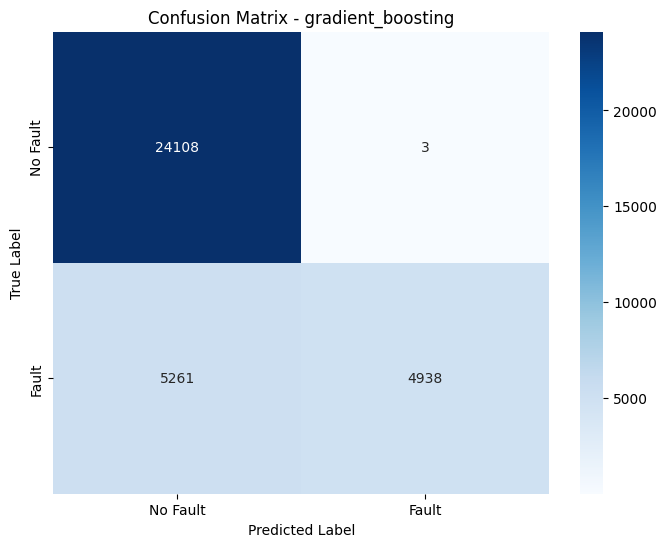

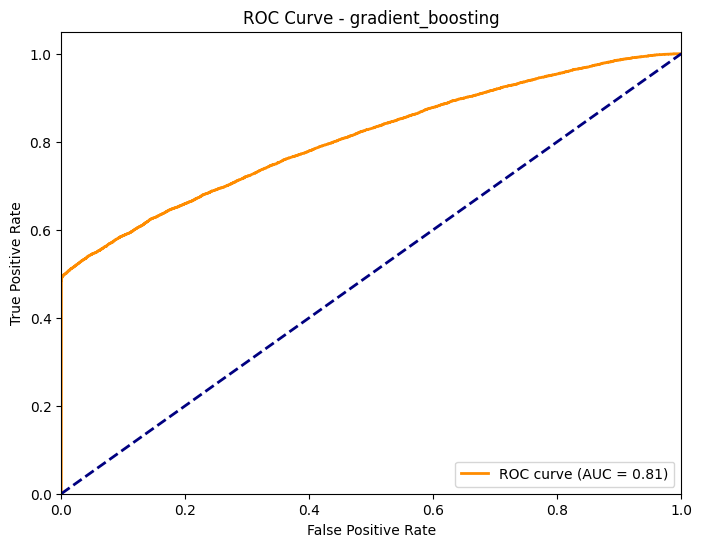

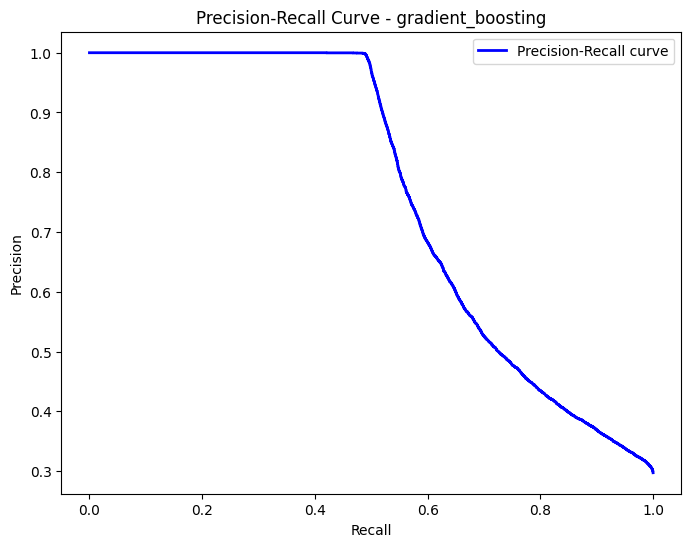


Evaluating binary model: logistic_regression

Performance Metrics:


,Score
Accuracy,0.757
Precision,0.745
Recall,0.757
F1 Score,0.726
AUC-ROC,0.722



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     24111
           1       0.69      0.33      0.45     10199

    accuracy                           0.76     34310
   macro avg       0.73      0.63      0.65     34310
weighted avg       0.74      0.76      0.73     34310



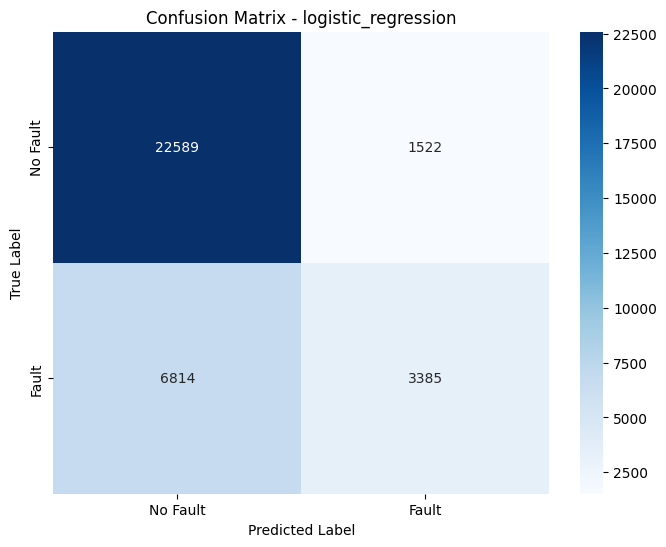

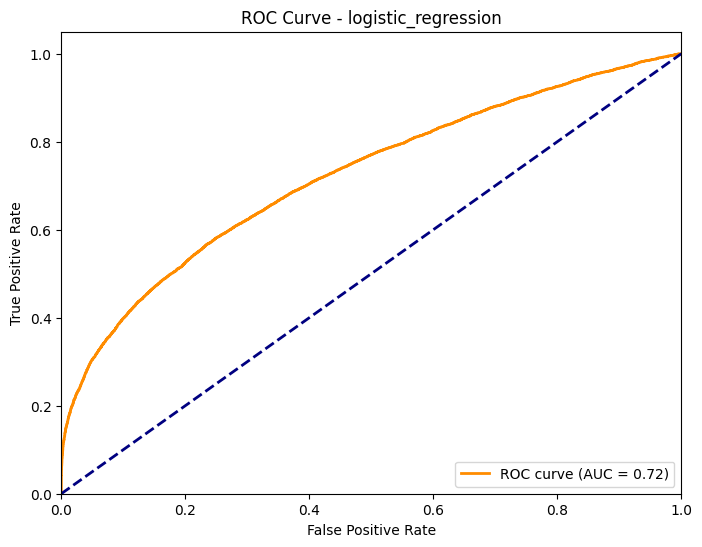

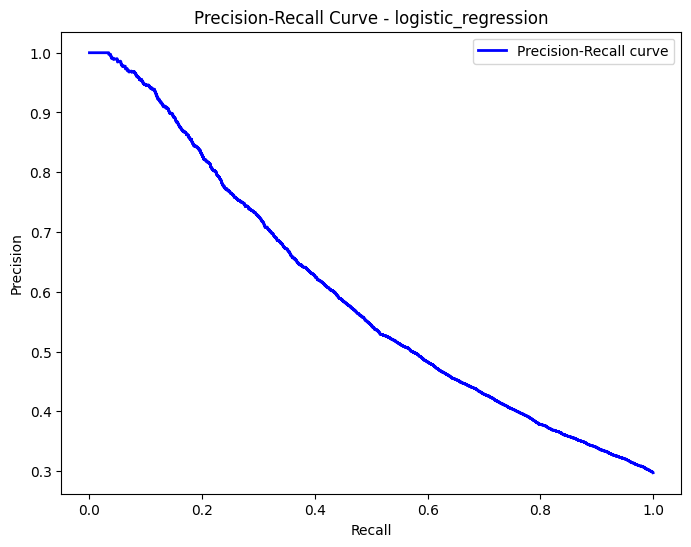


Evaluating binary model: xgboost

Performance Metrics:


,Score
Accuracy,0.867
Precision,0.885
Recall,0.867
F1 Score,0.854
AUC-ROC,0.927



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     24111
           1       0.98      0.56      0.72     10199

    accuracy                           0.87     34310
   macro avg       0.91      0.78      0.81     34310
weighted avg       0.89      0.87      0.85     34310



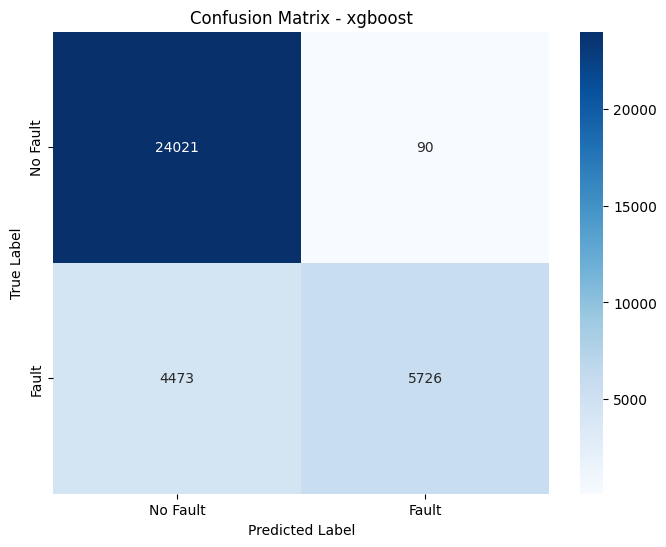

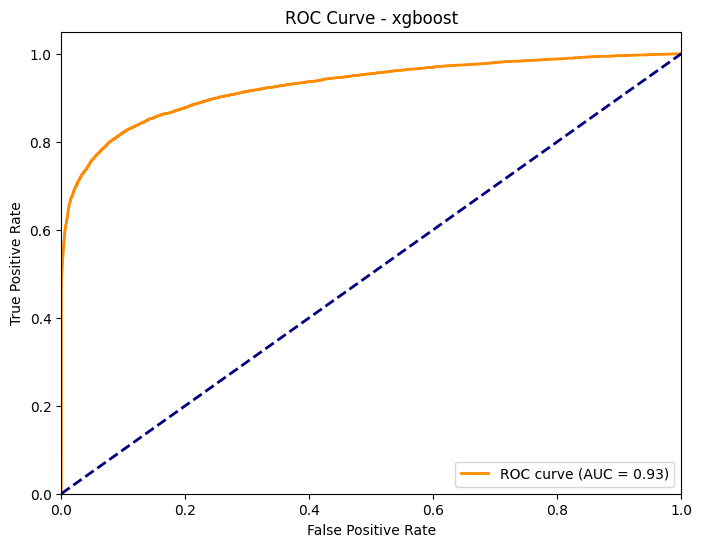

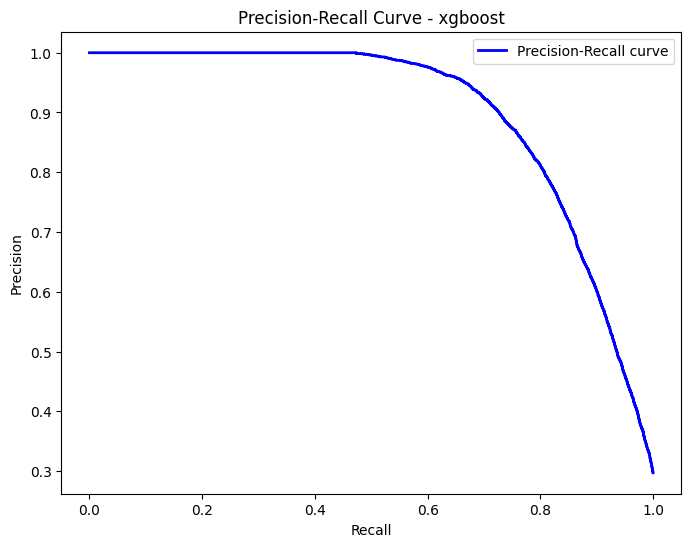


Evaluating binary model: random_forest

Performance Metrics:


,Score
Accuracy,0.968
Precision,0.970
Recall,0.968
F1 Score,0.968
AUC-ROC,0.989



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     24111
           1       1.00      0.89      0.94     10199

    accuracy                           0.97     34310
   macro avg       0.98      0.95      0.96     34310
weighted avg       0.97      0.97      0.97     34310



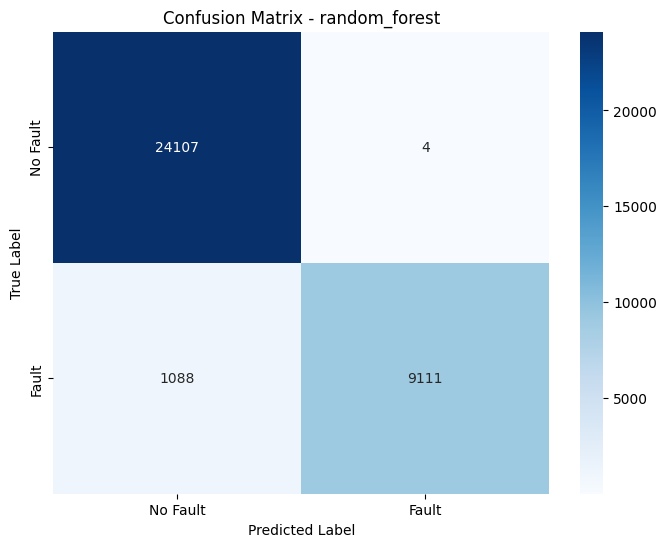

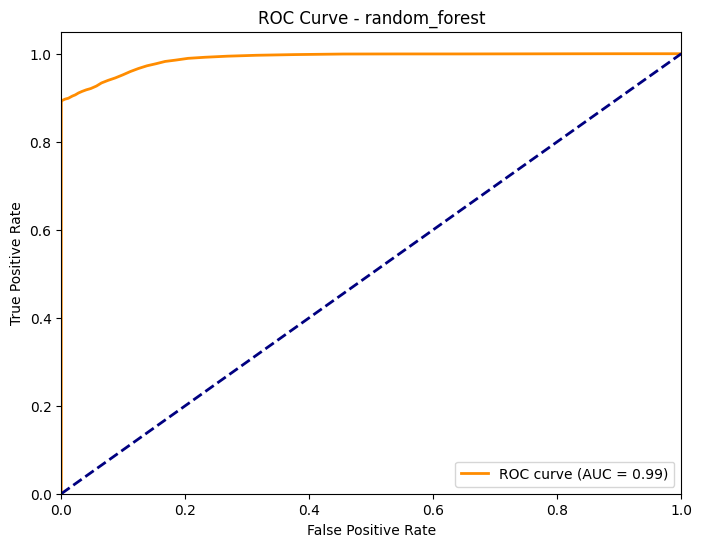

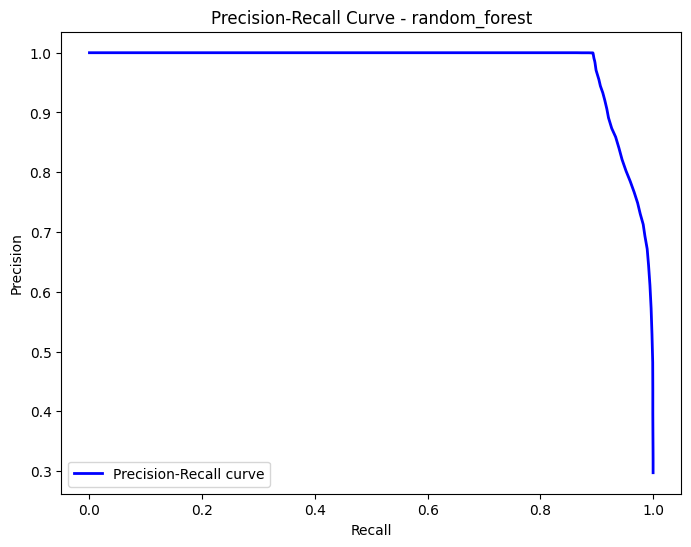


##################################################
### MULTICLASS CLASSIFICATION MODELS
##################################################

Evaluating multiclass model: gradient_boosting

Performance Metrics:


,Score
Accuracy,0.849
Precision,0.876
Recall,0.849
F1 Score,0.817
AUC-ROC (OvR),0.895



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     24111
           1       1.00      0.74      0.85      1706
           2       0.99      0.52      0.68      1720
           3       1.00      0.13      0.23      3359
           4       1.00      0.72      0.84      3414

    accuracy                           0.85     34310
   macro avg       0.96      0.62      0.70     34310
weighted avg       0.88      0.85      0.82     34310



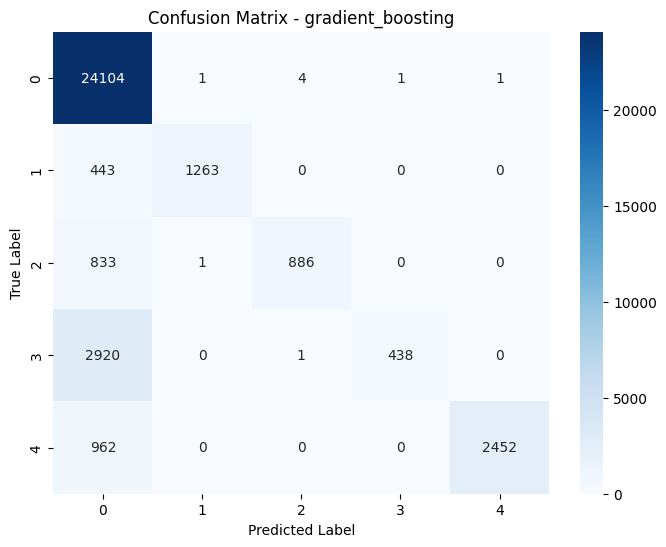


Evaluating multiclass model: xgboost

Performance Metrics:


,Score
Accuracy,0.873
Precision,0.892
Recall,0.873
F1 Score,0.851
AUC-ROC (OvR),0.967



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     24111
           1       0.99      0.79      0.88      1706
           2       1.00      0.59      0.74      1720
           3       1.00      0.24      0.39      3359
           4       1.00      0.78      0.88      3414

    accuracy                           0.87     34310
   macro avg       0.97      0.68      0.76     34310
weighted avg       0.89      0.87      0.85     34310



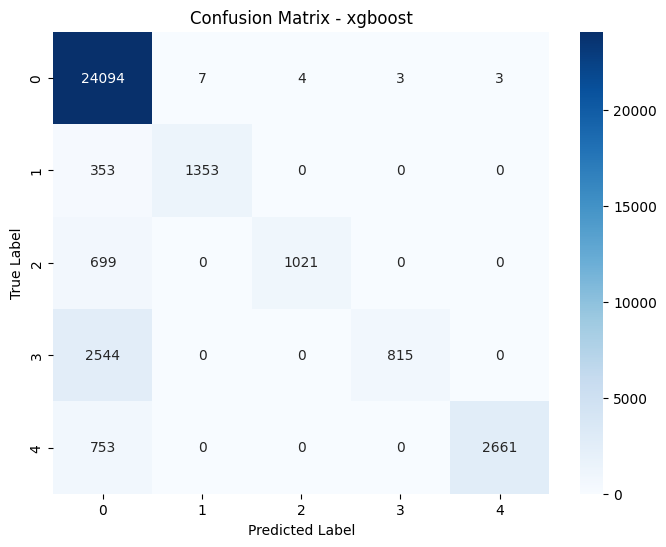


Evaluating multiclass model: random_forest

Performance Metrics:


,Score
Accuracy,0.968
Precision,0.970
Recall,0.968
F1 Score,0.967
AUC-ROC (OvR),0.988



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     24111
           1       1.00      0.94      0.97      1706
           2       1.00      0.89      0.94      1720
           3       1.00      0.82      0.90      3359
           4       1.00      0.94      0.97      3414

    accuracy                           0.97     34310
   macro avg       0.99      0.92      0.95     34310
weighted avg       0.97      0.97      0.97     34310



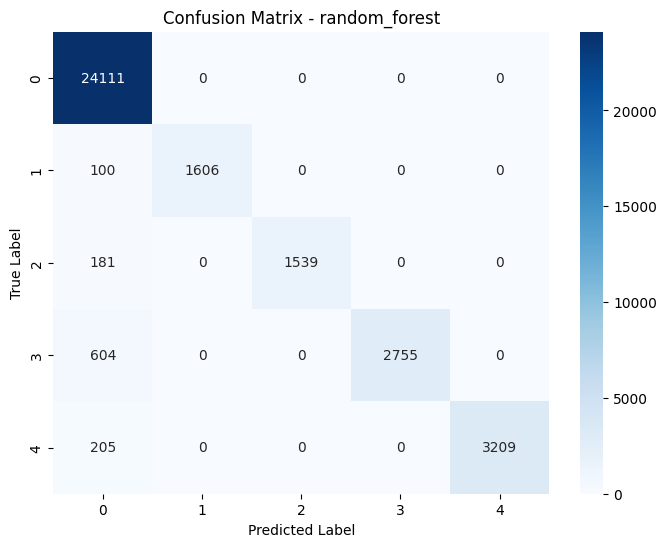

In [ ]:
# Evaluate all models with comprehensive reporting
results = {}

for model_type in models:
    results[model_type] = {}
    y_true = y_binary if model_type == 'binary' else y_multiclass

    print(f"\n{'#'*50}")
    print(f"### {model_type.upper()} CLASSIFICATION MODELS")
    print(f"{'#'*50}")

    for model_name, model in models[model_type].items():
        results[model_type][model_name] = evaluate_model(
            model, X, y_true, model_name, model_type
        )




MODEL PERFORMANCE COMPARISON

Overall Performance Comparison:


,Accuracy,Precision,Recall,F1 Score,AUC-ROC,AUC-ROC (OvR)
Model,,,,,,
binary_gradient_boosting,0.847,0.874,0.847,0.827,0.807,nan
binary_logistic_regression,0.757,0.745,0.757,0.726,0.722,nan
binary_xgboost,0.867,0.885,0.867,0.854,0.927,nan
binary_random_forest,0.968,0.970,0.968,0.968,0.989,nan
multiclass_gradient_boosting,0.849,0.876,0.849,0.817,nan,0.895
multiclass_xgboost,0.873,0.892,0.873,0.851,nan,0.967
multiclass_random_forest,0.968,0.970,0.968,0.967,nan,0.988


<Figure size 1200x600 with 0 Axes>

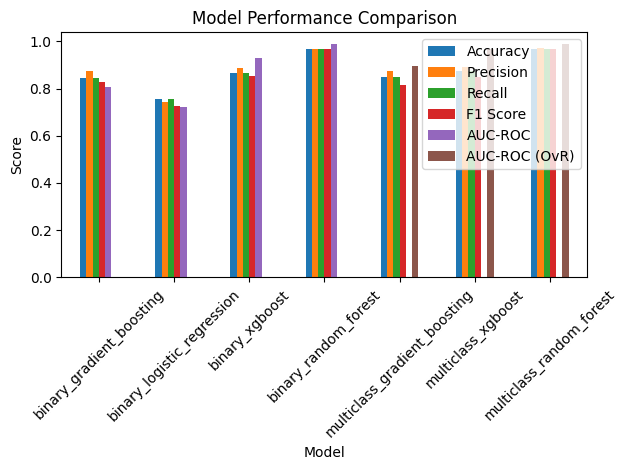

In [ ]:
# Create a comparison table of all models
print("\n\nMODEL PERFORMANCE COMPARISON")

comparison_data = []
for model_type in results:
    for model_name, metrics in results[model_type].items():
        if metrics:
            row = {'Model': f"{model_type}_{model_name}"}
            row.update(metrics)
            comparison_data.append(row)

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data).set_index('Model')

    # Highlight best scores for each metric
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    print("\nOverall Performance Comparison:")
    display(comparison_df.style.format("{:.3f}").apply(highlight_max))

    # Plot comparison
    plt.figure(figsize=(12, 6))
    comparison_df.plot(kind='bar', rot=45)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()
else:
    print("No valid results to compare")